In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error
from datetime import datetime

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor

In [3]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

## Import data

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train.head()

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,country_code,country,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,22267382,Modern and Cozy Large Studio in Brooklyn,Modern large studio with new amenities and app...,Our place is a little quiet sanctuary in the h...,Modern large studio with new amenities and app...,none,"BAM, Barclays, Brooklyn City Point, Fort Green...",NaN,"Subway: 2,3,4,5,A,C,B,Q,G",Washer/Dryer Dishwasher Internet Gym Roof Top ...,"Depending on the time of your visit, I'll be h...","- Please be respectful of our neighbors, no lo...",1910170,Katarina,2012-03-12,"Los Angeles, California, United States","Traveler, Artist, Philanthropist",NaN,NaN,NaN,f,Fort Greene,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Fort Greene,Brooklyn,Brooklyn,NY,11217,New York,US,United States,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Gym,Breakfast...",NaN,145.0,2,$30.00,7,12,6,2018-01-01,2018-07-03,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,flexible,f,f,1,0.59
1,2473861,Royal Harlem TRIPLEX Home 5 Beds,Harlem is back and so gorgeous! Visit and expl...,Harlem is back and so gorgeous! Visit and expl...,Harlem is back and so gorgeous! Visit and expl...,none,HARLEM is a piece of real NY history overflowi...,HARLEM RESTAURANTS Red Rooster Harlem -- excel...,PUBLIC TRANSPORTATION: Conveniently near all p...,The WHOLE ENTIRE HOUSE,NaN,"Smoking, pets and unaccounted guests NOT permi...",8826175,Grover,2013-09-14,"New York, New York, United States",As the owners of the property we have realized...,within an hour,100%,NaN,f,Mid-Wilshire,4.0,"['email', 'phone', 'reviews', 'manual_offline']",t,t,Harlem,Manhattan,New York,NY,10027,New York,US,United States,House,Entire home/apt,8,1.0,3.0,5.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",NaN,175.0,3,$19.00,3,30,137,2014-04-15,2018-10-20,91.0,9.0,9.0,9.0,9.0,9.0,9.0,t,f,moderate,f,f,3,2.47
2,25079703,Sunny East Village Studio,"Clean, hip and well designed sun drenched East...",This is a rare East Village studio with it's h...,"Clean, hip and well designed sun drenched East...",none,East Village is one of the last remaining neig...,NaN,NaN,You'll have access to the entire space - it's ...,"Very responsive via phone call, text or email.",NaN,4383563,Zander,2012-12-11,"New York, New York, United States","New York City based, currently working as a te...",within a few hours,100%,NaN,f,East Village,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,East Village,Manhattan,New York,NY,10009,New York,US,United States,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,""S...",NaN,180.0,1,$0.00,2,1125,3,2018-07-26,2018-10-14,100.0,10.0,9.0,9.0,10.0,10.0,10.0,f,f,moderate,f,f,1,0.89
3,9342478,"Beautiful, airy, light-filled room","Private, spacious, comfortable room in 2-bed f...","Big closet, two big windows, tall ceiling and ...","Private, spacious, comfortable room in 2-bed f...",none,One block from Morgan L stop. Super cool area....,NaN,NaN,NaN,NaN,NaN,10406276,Kathleen,2013-12-03,"New York, New York, United States",Australia

## Check for missing values

In [6]:
mdf = train.isnull().sum(axis=0).reset_index()
mdf.columns = ['column_name', 'missing_count']
mdf = mdf.loc[mdf['missing_count']>0]
mdf = mdf.sort_values(by='missing_count')
mdf

,column_name,missing_count
22,host_listings_count,5
25,host_identity_verified,5
24,host_has_profile_pic,5
20,host_is_superhost,5
14,host_since,5
13,host_name,5
29,state,10
1,name,12
39,beds,31
38,bedrooms,33


## Cleaning

In [7]:
def ny(x):
    """Gets one format of NY"""
    if x == 'Ny' or x == 'ny' or x=='New York' or pd.isnull(x):
        return 'NY'
    else:
        return x
    
def city(x):
    """Gets all values into lower case and does translations"""
    if x == '纽约法拉盛':
        return 'flushing'
    if x == '布鲁克林':
        return 'brooklyn'
    if x == '紐約' or x == '纽约市' or x == '纽约市':
        return 'new york'
    else:
        return str(x).lower()
    
def market(x):
    """Make all markets equal 'New York'"""
    if x != 'New York':
        return 'New York'
    else:
        return x
    
def zipcode(x):
    if x == '11249\n11249':
        return '11249'
    if x == '11413-3220':
        return '11413'
    if x == '11103-3233':
        return '11103'
    if x == "10002-2289":
        return '10002'
    if x == '10457-7806':
        return '10457'
    if x == "-- default zip code --":
        return '0'
    if x == '11692-2304':
        return '11692'
    if x == "1m":
        return '0'
    else:
        ok = round(pd.to_numeric(x))
        ok = str(ok).strip('.0')
        return ok

In [8]:
# host_listings_count
train['host_listings_count'] = train['host_listings_count'].fillna(0)
test['host_listings_count'] = test['host_listings_count'].fillna(0)

# host_identity_verified
train.loc[train.host_identity_verified == 't', 'host_identity_verified'] = 1
train.loc[train.host_identity_verified == 'f', 'host_identity_verified'] = 0
train['host_identity_verified'] = test['host_identity_verified'].fillna(0)

test.loc[train.host_identity_verified == 't', 'host_identity_verified'] = 1
test.loc[train.host_identity_verified == 'f', 'host_identity_verified'] = 0
test['host_identity_verified'] = test['host_identity_verified'].fillna(0)

# host_has_profile_pic
train.loc[train.host_has_profile_pic == 't', 'host_has_profile_pic'] = 1
train.loc[train.host_has_profile_pic == 'f', 'host_has_profile_pic'] = 0
train['host_has_profile_pic'] = train['host_has_profile_pic'].fillna(0)

test.loc[train.host_has_profile_pic == 't', 'host_has_profile_pic'] = 1
test.loc[train.host_has_profile_pic == 'f', 'host_has_profile_pic'] = 0
test['host_has_profile_pic'] = test['host_has_profile_pic'].fillna(0)

# host_is_super_host
train.loc[train.host_is_superhost == 't', 'host_is_superhost'] = 1
train.loc[train.host_is_superhost == 'f', 'host_is_superhost'] = 0
train['host_is_superhost'] = train['host_is_superhost'].fillna(0)

test.loc[train.host_is_superhost == 't', 'host_is_superhost'] = 1
test.loc[train.host_is_superhost == 'f', 'host_is_superhost'] = 0
test['host_is_superhost'] = test['host_is_superhost'].fillna(0)

# host_since
train['host_since'] = train['host_since'].fillna('00-00-00')
test['host_since'] = test['host_since'].fillna('00-00-00')

# host_name
train['host_name'] = train['host_name'].fillna('Unknown')
test['host_name'] = test['host_name'].fillna('Unknown')

# bathrooms
train['bathrooms'] = train['bathrooms'].fillna(0)
test['bathrooms'] = test['bathrooms'].fillna(0)

# bedrooms
train['bedrooms'] = train['bedrooms'].fillna(0)
test['bedrooms'] = test['bedrooms'].fillna(0)

# beds
train['beds'] = train['beds'].fillna(0)
test['beds'] = test['beds'].fillna(0)

# state: mp, nj, ca are still in dataset
train['state'] = train['state'].apply(ny)
test['state'] = test['state'].apply(ny)

# name
train['name'] = train['name'].fillna('Unknown')
test['name'] = test['name'].fillna('Unknown')

# city
train['city'] = train['city'].apply(city)
test['city'] = test['city'].apply(city)

# market
train['market'] = train['market'].apply(market)
test['market'] = test['market'].apply(market)

# host_location
train['host_location'] = train['host_location'].fillna('Unknown')
test['host_location'] = test['host_location'].fillna('Unknown')

# description
train['description'] = train['description'].fillna('none')
test['description'] = test['description'].fillna('none')

# zipcode
train['zipcode'] = train['zipcode'].fillna(0)
test['zipcode'] = test['zipcode'].fillna(0)
train['zipcode'] = train['zipcode'].apply(zipcode)
test['zipcode'] = test['zipcode'].apply(zipcode)

# summary
train['summary'] = train['summary'].fillna('none')
test['summary'] = test['summary'].fillna('none')

# host_neighbourhood
train['host_neighbourhood'] = train['host_neighbourhood'].fillna('none')
test['host_neighbourhood'] = test['host_neighbourhood'].fillna('none')

# first_review
train['first_review'] = train['first_review'].fillna('00-00-00')
test['first_review'] = test['first_review'].fillna('00-00-00')

# last_review
train['last_review'] = train['last_review'].fillna(0)
test['last_review'] = test['last_review'].fillna(0)

# reviews_per_month
train['reviews_per_month'] = train['reviews_per_month'].fillna(0)
test['reviews_per_month'] = test['reviews_per_month'].fillna(0)

# 'review_scores_rating','review_scores_cleanliness', 'review_scores_communication', 
#'review_scores_accuracy', 'review_scores_location', 'review_scores_checkin', 'review_scores_value'

scores= ['review_scores_rating','review_scores_cleanliness', 'review_scores_communication', 
       'review_scores_accuracy', 'review_scores_location', 'review_scores_checkin', 'review_scores_value']
for i in scores:
    train[i] = train[i].fillna(0)
    test[i] = train[i].fillna(0)
    
# space
train['space'] = train['space'].fillna('none')
test['space'] = test['space'].fillna('none')

# transit
train['transit'] = train['transit'].fillna('none')
test['transit'] = test['transit'].fillna('none')

# house_rules, host_about, neighborhood_overview, access, interaction, notes
lst = ['house_rules', 'host_about', 'neighborhood_overview', 'access', 'interaction', 'notes']
for i in lst:
    train[i] = train[i].fillna('none')
    test[i] = train[i].fillna('none')

# host_response_rate
train['host_response_rate'] = train['host_response_rate'].str.replace('%','')
train['host_response_rate'] = train['host_response_rate'].fillna('0')
train['host_response_rate'] = pd.to_numeric(train['host_response_rate'])
test['host_response_rate'] = test['host_response_rate'].str.replace('%','')
test['host_response_rate'] = test['host_response_rate'].fillna('0')
test['host_response_rate'] = pd.to_numeric(test['host_response_rate'])

# host_response_time
train['host_response_time'] = train['host_response_time'].fillna('none')
test['host_response_time'] = test['host_response_time'].fillna('none')

# host_identity_verified
train.loc[train.host_identity_verified == 't', 'host_identity_verified'] = 1
train.loc[train.host_identity_verified == 'f', 'host_identity_verified'] = 0
train['host_identity_verified'] = train['host_identity_verified'].fillna(0)
test.loc[test.host_identity_verified == 't', 'host_identity_verified'] = 1
test.loc[test.host_identity_verified == 'f', 'host_identity_verified'] = 0
test['host_identity_verified'] = test['host_identity_verified'].fillna(0)

# host_acceptance_rate
train['host_acceptance_rate'] = train['host_acceptance_rate'].fillna(0)
test['host_acceptance_rate'] = test['host_acceptance_rate'].fillna(0)

# square_feet
train['square_feet'] = train['square_feet'].fillna(0)
test['square_feet'] = test['square_feet'].fillna(0)

# extra_people
train['extra_people'] = train['extra_people'].str.replace('$', '')
train['extra_people'] = pd.to_numeric(train['extra_people'])
test['extra_people'] = test['extra_people'].str.replace('$', '')
test['extra_people'] = pd.to_numeric(test['extra_people'])

# IDs
train['id'] = train['id'].apply(lambda x: str(x))
train['host_id'] = train['host_id'].apply(lambda x: str(x))
test['id'] = test['id'].apply(lambda x: str(x))
test['host_id'] = test['host_id'].apply(lambda x: str(x))

# tf
tf = ['instant_bookable','is_business_travel_ready','require_guest_profile_picture','calculated_host_listings_count']
for i in tf:
    train[i].apply(lambda x: 1 if x == 't' else 0)
    test[i].apply(lambda x: 1 if x == 't' else 0)

/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [9]:
train["last_review"] = pd.to_datetime(train["last_review"])
test["last_review"] = pd.to_datetime(test["last_review"])
print(test["last_review"].max())

2018-11-03 00:00:00


In [10]:
train["last_review"]=train["last_review"].apply(lambda x: dt.datetime(2018,11,3)-x)
train["last_review"]=train["last_review"].dt.days.astype("int")
test["last_review"]=test["last_review"].apply(lambda x: dt.datetime(2018,11,3)-x)
test["last_review"]=test["last_review"].dt.days.astype("int")


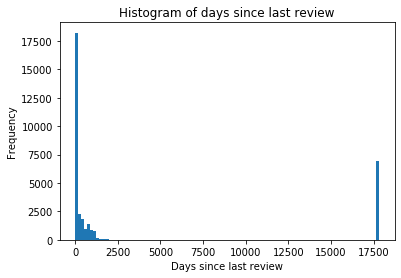

In [11]:
plt.hist(train["last_review"], bins=100)
plt.ylabel("Frequency")
plt.xlabel("Days since last review")
plt.ylabel("Frequency")
plt.title("Histogram of days since last review")
plt.show()

In [12]:
okman = train['last_review'].tolist()
okman = list(set(okman))
def Range(list1):  
    largest = list1[0]  
    lowest = list1[0]  
    largest2 = None
    lowest2 = None
    for item in list1[1:]:      
        if item > largest:  
            largest2 = largest 
            largest = item  
        elif largest2 == None or largest2 < item:  
            largest2 = item  
        if item < lowest:  
            lowest2 = lowest 
            lowest = item  
        elif lowest2 == None or lowest2 > item:  
            lowest2 = item  
              
    print("Largest element is:", largest)  
    print("Smallest element is:", lowest)  
    print("Second Largest element is:", largest2)  
    print("Second Smallest element is:", lowest2)
          
Range(okman)

Largest element is: 17838
Smallest element is: 0
Second Largest element is: 3063
Second Smallest element is: 1


In [13]:
train["last_review"]=train["last_review"].replace(17838, 3063)
test["last_review"]=test["last_review"].replace(17838, 3063)


In [14]:
def date_replacement(date):
    if date <=3:
        return "Last_review_last_three_day"
    elif date <= 7:
        return "Last_review_last_week"
    elif date <= 30:
        return "Last_review_last_month"
    elif date <= 183:
        return "Last_review_last_half_year"
    elif date <= 365:
        return "Last_review_last year"
    elif date <= 1825:
        return "Last_review_last_5_years"
    else:
        return "Last_review_never" 

    
train["last_review"]=train["last_review"].apply(lambda x: date_replacement(x))
test["last_review"]=test["last_review"].apply(lambda x: date_replacement(x))

In [15]:
rev= train['last_review'].unique().tolist()
rev

['Last_review_last_half_year',
 'Last_review_last_month',
 'Last_review_never',
 'Last_review_last_5_years',
 'Last_review_last_three_day',
 'Last_review_last year',
 'Last_review_last_week']

In [16]:
train = train[train.price != 0].copy()
train.shape

(33522, 65)

## No missing values

In [17]:
mdf = train.isnull().sum(axis=0).reset_index()
mdf.columns = ['column_name', 'missing_count']
mdf = mdf.loc[mdf['missing_count']>0]
mdf= mdf.sort_values(by='missing_count')
mdf

,column_name,missing_count


## Feature selection

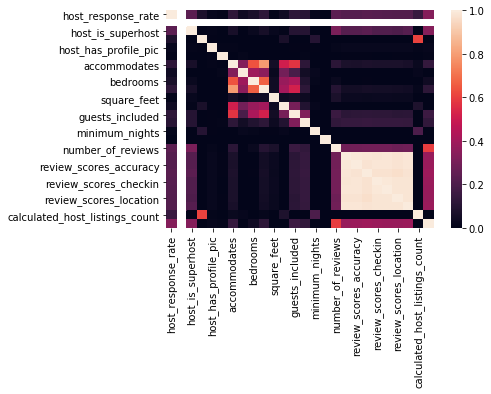

In [18]:
heat = sns.heatmap(train.corr(), vmin=0, vmax=1)
heat;

In [19]:
train_corr = train.corr()
train_corr

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
host_response_rate,1.000000,NaN,0.236893,0.074844,0.015633,0.006141,0.124369,0.041990,0.068438,0.118330,0.007501,0.040229,0.121796,0.105847,0.014339,-0.005561,0.234423,0.219851,0.221445,0.229381,0.223923,0.220719,0.216728,0.215690,0.146645,0.335686
host_acceptance_rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
host_is_superhost,0.236893,NaN,1.000000,-0.023970,0.011514,-0.003424,0.063193,-0.003617,0.026035,0.060531,0.022279,0.010928,0.100046,0.100958,-0.052807,-0.002469,0.311198,0.224528,0.222796,0.237832,0.214372,0.213624,0.203421,0.223730,-0.000446,0.334106
host_listings_count,0.074844,NaN,-0.023970,1.000000,0.004478,-0.002070,0.001052,0.000236,-0.028373,-0.002150,-0.005203,0.066802,-0.000623,-0.051292,0.097789,-0.000581,-0.045810,-0.104704,-0.106223,-0.100549,-0.104280,-0.105924,-0.102167,-0.109176,0.607346,-0.058050
host_has_profile_pic,0.015633,NaN,0.011514,0.004478,1.000000,0.009274,0.009890,-0.005030,-0.004123,0.003638,0.003641,-0.013670,0.005412,0.006998,0.004725,0.000249,0.012226,0.022176,0.020843,0.021312,0.021749,0.021321,0.020649,0.021015,0.009268,0.017321
host_identity_verified,0.006141,NaN,-0.003424,-0.002070,0.009274,1.000000,0.000171,0.014413,0.000937,-0.001805,-0.004347,0.001183,0.000922,0.008490,0.001333,-0.003302,-0.003264,0.004786,0.004659,0.003991,0.003485,0.003839,0.004038,0.004995,-0.006770,0.008966
accommodates,0.124369,NaN,0.063193,0.001052,0.009890,0.000171,1.000000,0.328997,0.637872,0.792996,0.051880,0.513450,0.575570,0.120592,-0.009573,-0.005528,0.114406,0.070780,0.069933,0.077775,0.072867,0.072661,0.071874,0.065577,0.024818,0.138118
bathrooms,0.041990,NaN,-0.003617,0.000236,-0.005030,0.014413,0.328997,1.000000,0.392833,0.354347,0.026712,0.295572,0.193286,0.047297,0.023008,-0.001811,-0.017243,-0.025208,-0.026735,-0.025632,-0.027699,-0.029057,-0.026664,-0.024994,0.019310,0.002635
bedrooms,0.068438,NaN,0.026035,-0.028373,-0.004123,0.000937,0.637872,0.392833,1.000000,0.664660,0.044443,0.380754,0.422800,0.089095,0.014514,-0.008571,0.026404,0.002074,-0.000114,0.004496,0.002284,0.001689,-0.000972,0.001230,-0.032569,0.040345
beds,0.118330,NaN,0.060531,-0.002150,0.003638,-0.001805,0.792996,0.354347,0.664660,1.000000,0.045700,0.408502,0.521479,0.118655,0.006709,-0.003003,0.099051,0.049873,0.047911,0.056106,0.052769,0.051468,0.050213,0.046067,0.011933,0.117564


In [20]:
cmap=sns.diverging_palette(5, 250, as_cmap=True)

# def magnify():
#     return [dict(selector="th",
#                  props=[("font-size", "7pt")]),
#             dict(selector="td",
#                  props=[('padding', "0em 0em")]),
#             dict(selector="th:hover",
#                  props=[("font-size", "12pt")]),
#             dict(selector="tr:hover td:hover",
#                  props=[('max-width', '200px'),
#                         ('font-size', '12pt')])
# ]

train_corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    #.set_table_styles(magnify())

/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
host_response_rate,1.00,nan,0.24,0.07,0.02,0.01,0.12,0.04,0.07,0.12,0.01,0.04,0.12,0.11,0.01,-0.01,0.23,0.22,0.22,0.23,0.22,0.22,0.22,0.22,0.15,0.34
host_acceptance_rate,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
host_is_superhost,0.24,nan,1.00,-0.02,0.01,-0.00,0.06,-0.00,0.03,0.06,0.02,0.01,0.10,0.10,-0.05,-0.00,0.31,0.22,0.22,0.24,0.21,0.21,0.20,0.22,-0.00,0.33
host_listings_count,0.07,nan,-0.02,1.00,0.00,-0.00,0.00,0.00,-0.03,-0.00,-0.01,0.07,-0.00,-0.05,0.10,-0.00,-0.05,-0.10,-0.11,-0.10,-0.10,-0.11,-0.10,-0.11,0.61,-0.06
host_has_profile_pic,0.02,nan,0.01,0.00,1.00,0.01,0.01,-0.01,-0.00,0.00,0.00,-0.01,0.01,0.01,0.00,0.00,0.01,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.02
host_identity_verified,0.01,nan,-0.00,-0.00,0.01,1.00,0.00,0.01,0.00,-0.00,-0.00,0.00,0.00,0.01,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,0.01
accommodates,0.12,nan,0.06,0.00,0.01,0.00,1.00,0.33,0.64,0.79,0.05,0.51,0.58,0.12,-0.01,-0.01,0.11,0.07,0.07,0.08,0.07,0.07,0.07,0.07,0.02,0.14
bathrooms,0.04,nan,-0.00,0.00,-0.01,0.01,0.33,1.00,0.39,0.35,0.03,0.30,0.19,0.05,0.02,-0.00,-0.02,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.02,0.02,0.00
bedrooms,0.07,nan,0.03,-0.03,-0.00,0.00,0.64,0.39,1.00,0.66,0.04,0.38,0.42,0.09,0.01,-0.01,0.03,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.03,0.04
beds,0.12,nan,0.06,-0.00,0.00,-0.00,0.79,0.35,0.66,1.00,0.05,0.41,0.52,0.12,0.01,-0.00,0.10,0.05,0.05,0.06,0.05,0.05,0.05,0.05,0.01,0.12


## Features with high correlation
* accomodates: 0.51
* bathrooms: 0.30
* bedrooms: 0.38
* beds: 0.41
* guests_included: 0.30

In [21]:
num = train.corr().columns.tolist()
feats = ['accommodates','bathrooms','bedrooms','beds', 'guests_included', 'price','extra_people', 'host_listings_count']
test_num = test.corr().columns.tolist()
# feat_list = columns we don't want
feat_list = np.setdiff1d(num,feats).tolist()
test_feat_list = np.setdiff1d(test_num, feats).tolist()

In [22]:
rtrain = train.drop(columns=feat_list)
rtest = test.drop(columns=test_feat_list)
print(rtrain.shape)
print(rtest.shape)

(33522, 47)
(17337, 48)


In [23]:
rtest.shape

(17337, 48)

In [24]:
ohtest = rtest[['accommodates','bathrooms','bedrooms','beds', 'guests_included','extra_people', 'host_listings_count']]

In [25]:
oh = rtrain[feats]
X = oh.drop(columns='price')
y = oh['price']
reg = LinearRegression().fit(X, y)
pred = reg.predict(X)
rmse = np.sqrt(mean_squared_error(y, pred))
rmse

112.15177106086774

In [26]:
testpred = reg.predict(ohtest)

In [27]:
# neighborhood_cleansed?
rtrain = rtrain[['neighbourhood_group_cleansed','neighbourhood_cleansed', 'room_type', 'accommodates', 
        'bathrooms', 'bedrooms', 'beds',
        'guests_included','description','last_review','extra_people', 'host_listings_count','price']]


rtest = rtest[['neighbourhood_group_cleansed', 'neighbourhood_cleansed','room_type', 'accommodates', 
        'bathrooms', 'bedrooms', 'beds',
        'guests_included','description','last_review','extra_people', 'host_listings_count']]


In [28]:
rtrain

,neighbourhood_group_cleansed,neighbourhood_cleansed,room_type,accommodates,bathrooms,bedrooms,beds,guests_included,description,last_review,extra_people,host_listings_count,price
0,Brooklyn,Fort Greene,Entire home/apt,2,1.0,1.0,1.0,2,Modern large studio with new amenities and app...,Last_review_last_half_year,30.0,1.0,145.0
1,Manhattan,Harlem,Entire home/apt,8,1.0,3.0,5.0,3,Harlem is back and so gorgeous! Visit and expl...,Last_review_last_month,19.0,4.0,175.0
2,Manhattan,East Village,Entire home/apt,2,1.0,0.0,1.0,1,"Clean, hip and well designed sun drenched East...",Last_review_last_month,0.0,1.0,180.0
3,Brooklyn,Williamsburg,Private room,1,1.0,1.0,1.0,1,"Private, spacious, comfortable room in 2-bed f...",Last_review_never,0.0,1.0,42.0
4,Brooklyn,Boerum Hill,Private room,2,1.0,1.0,1.0,1,"Comfy, quiet and big private room in a three b...",Last_review_last_month,14.0,1.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,Manhattan,East Village,Private room,2,1.0,1.0,1.0,1,"Private room in cozy, sun-drenched & plant fil...",Last_review_last_5_years,25.0,1.0,110.0
33534,Manhattan,Theater District,Entire home/apt,8,3.0,4.0,4.0,1,This is a beautiful four bedroom and three bat...,Last_review_last_week,0.0,3.0,1195.0
33535,Queens,Woodside,Private room,1,0.0,1.0,1.0,1,Room for rent in duplex house located in Astor...,Last_review_never,0.0,1.0,50.0
33536,Manhattan,Washington Heights,Private room,2,1.0,1.0,1.0,1,Very spacious bright beautiful apartment in Wa...,Last_review_last year,0.0,4.0,60.0


In [29]:
cats = ['neighbourhood_group_cleansed','room_type','neighbourhood_cleansed','last_review']
for i in cats:
    rtrain = pd.concat([rtrain, pd.get_dummies(rtrain[i], drop_first=False)], axis=1)
    rtrain.drop([i],axis=1, inplace=True)
    rtest = pd.concat([rtest, pd.get_dummies(rtest[i], drop_first=False)], axis=1)
    rtest.drop([i],axis=1, inplace=True)

In [30]:
print(rtrain.shape)
print(rtest.shape)

(33522, 244)
(17337, 230)


In [31]:
rtrain_corr = rtrain.corr()
rtrain_corr.tail(10)

,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,host_listings_count,price,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,Clifton,Clinton Hill,Co-op City,Cobble Hill,College Point,Columbia St,Concord,Concourse,Concourse Village,Coney Island,Corona,Crown Heights,Cypress Hills,DUMBO,Ditmars Steinway,Dongan Hills,Douglaston,Downtown Brooklyn,Dyker Heights,East Elmhurst,East Flatbush,East Harlem,East Morrisania,East New York,East Village,Eastchester,Edenwald,Edgemere,Elmhurst,Eltingville,Emerson Hill,Far Rockaway,Fieldston,Financial District,Flatbush,Flatiron District,Flatlands,Flushing,Fordham,Forest Hills,Fort Greene,Fort Hamilton,Fresh Meadows,Gerritsen Beach,Glendale,Gowanus,Gramercy,Graniteville,Grant City,Gravesend,Great Kills,Greenpoint,Greenwich Village,Grymes Hill,Harlem,Hell's Kitchen,Highbridge,Hollis,Holliswood,Howard Beach,Howland Hook,Hunts Point,Inwood,Jackson Heights,Jamaica,Jamaica Estates,Jamaica Hills,Kensington,Kew Gardens,Kew Gardens Hills,Kingsbridge,Kips Bay,Laurelton,Lighthouse Hill,Little Italy,Little Neck,Long Island City,Longwood,Lower East Side,Manhattan Beach,Marble Hill,Mariners Harbor,Maspeth,Melrose,Middle Village,Midland Beach,Midtown,Midwood,Mill Basin,Morningside Heights,Morris Heights,Morris Park,Morrisania,Mott Haven,Mount Eden,Mount Hope,Murray Hill,Navy Yard,Neponsit,New Brighton,New Dorp,New Dorp Beach,New Springville,NoHo,Nolita,North Riverdale,Norwood,Oakwood,Olinville,Ozone Park,Park Slope,Parkchester,Pelham Bay,Pelham Gardens,Pleasant Plains,Port Morris,Port Richmond,Prince's Bay,Prospect Heights,Prospect-Lefferts Gardens,Queens Village,Randall Manor,Red Hook,Rego Park,Richmond Hill,Ridgewood,Riverdale,Rockaway Beach,Roosevelt Island,Rosebank,Rosedale,Rossville,Schuylerville,Sea Gate,Sheepshead Bay,Shore Acres,Silver Lake,SoHo,Soundview,South Beach,South Ozone Park,South Slope,Springfield Gardens,Spuyten Duyvil,St. Albans,St. George,Stapleton,Stuyvesant Town,Sunnyside,Sunset Park,Theater District,Throgs Neck,Todt Hill,Tompkinsville,Tottenville,Tremont,Tribeca,Two Bridges,Unionport,University Heights,Upper East Side,Upper West Side,Van Nest,Vinegar Hill,Wakefield,Washington Heights,West Brighton,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Woodside,Last_review_last year,Last_review_last_5_years,Last_review_last_half_year,Last_review_last_month,Last_review_last_three_day,Last_review_last_week,Last_review_never
Woodlawn,-0.008932,-0.004720,-0.000637,-0.007805,-0.000969,0.001743,-0.001251,-0.009180,0.102614,-0.011899,-0.013355,-0.005068,-0.001158,-0.006866,0.003403,0.011617,-0.000362,-0.000079,-0.000237,-0.000581,-0.001974,-0.000223,-0.000506,-0.000750,-0.000158,-0.000079,-0.000193,-0.000447,-0.000273,-0.004004,-0.000158,-0.000223,-0.000295,-0.000500,-0.000250,-0.000922,-0.000758,-0.000112,-0.000467,-0.000512,-0.000273,-0.000791,-0.000530,-0.000137,-0.003312,-0.000306,-0.000724,-0.000998,-0.000158,-0.000137,-0.002244,-0.001232,-0.000193,-0.000542,-0.000316,-0.000316,-0.000209,-0.001580,-0.000158,-0.000698,-0.000250,-0.000418,-0.000285,-0.000474,-0.000403,-0.000285,-0.000487,-0.002608,-0.000729,-0.000410,-0.001219,-0.000112,-0.000193,-0.000575,-0.000344,-0.000806,-0.001300,-0.002228,-0.000158,-0.000909,-0.002965,-0.000193,-0.000223,-0.000193,-0.001020,-0.000079,-0.000112,-0.000335,-0.000262,-0.001645,-0.001644,-0.000666,-0.000542,-0.001314,-0.

In [32]:
# cmap=sns.diverging_palette(5, 250, as_cmap=True)

# # def magnify():
# #     return [dict(selector="th",
# #                  props=[("font-size", "7pt")]),
# #             dict(selector="td",
# #                  props=[('padding', "0em 0em")]),
# #             dict(selector="th:hover",
# #                  props=[("font-size", "12pt")]),
# #             dict(selector="tr:hover td:hover",
# #                  props=[('max-width', '200px'),
# #                         ('font-size', '12pt')])
# # ]

# rtrain_corr.style.background_gradient(cmap, axis=1)\
#     .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
#     .set_caption("Hover to magify")\
#     .set_precision(2)\
#     #.set_table_styles(magnify())

In [33]:
# get rtrain without target variable
price = rtrain['price']

In [34]:
print(rtrain.shape)
print(rtest.shape)

(33522, 244)
(17337, 230)


In [35]:
def lower(x):
    return x.lower()
rtrain['comfortable'] = rtrain['description'].apply(lower)
rtest['comfortable'] = rtest['description'].apply(lower)

def comfonehot(x):
    if 'comfortable' in x or 'comfy' in x or 'cozy' in x:
        return 1
    else:
        return 0
rtrain['comfortable'] = rtrain['description'].apply(comfonehot)
rtest['comfortable'] = rtest['description'].apply(comfonehot)

def ladyonehot(x):
    if 'lady' in x:
        return 1
    else:
        return 0
rtrain['lady'] = rtrain['description'].apply(ladyonehot)
rtest['lady'] = rtest['description'].apply(ladyonehot)

def girlonehot(x):
    if 'girl' in x:
        return 1
    else:
        return 0
rtrain['girl'] = rtrain['description'].apply(girlonehot)
rtest['girl'] = rtest['description'].apply(girlonehot)

def awesomeonehot(x):
    if 'awesome' in x:
        return 1
    else:
        return 0
    
rtrain['awesome'] = rtrain['description'].apply(awesomeonehot)
rtest['awesome'] = rtest['description'].apply(awesomeonehot)

def luxonehot(x):
    if 'luxury' in x or 'luxurious' in x:
        return 1
    else:
        return 0
    
rtrain['lux'] = rtrain['description'].apply(luxonehot)
rtest['lux'] = rtest['description'].apply(luxonehot)


def grandonehot(x):
    if 'grand' in x:
        return 1
    else:
        return 0
    
rtrain['grand'] = rtrain['description'].apply(grandonehot)
rtest['grand'] = rtest['description'].apply(grandonehot)

# patio, remodel, luxurious, clean, modern, and cozy
def patioonehot(x):
    if 'grand' in x:
        return 1
    else:
        return 0
    
rtrain['patio'] = rtrain['description'].apply(patioonehot)
rtest['patio'] = rtest['description'].apply(patioonehot)

def reonehot(x):
    if 'remodel' in x or 'remodelled' in x:
        return 1
    else:
        return 0
    
rtrain['remodel'] = rtrain['description'].apply(reonehot)
rtest['remodel'] = rtest['description'].apply(reonehot)

def cleanonehot(x):
    if 'clean' in x:
        return 1
    else:
        return 0
    
rtrain['clean'] = rtrain['description'].apply(cleanonehot)
rtest['clean'] = rtest['description'].apply(cleanonehot)

def modernonehot(x):
    if 'modern' in x:
        return 1
    else:
        return 0
    
rtrain['modern'] = rtrain['description'].apply(modernonehot)
rtest['modern'] = rtest['description'].apply(modernonehot)

def viewonehot(x):
    if 'view' in x:
        return 1
    else:
        return 0
    
rtrain['view'] = rtrain['description'].apply(viewonehot)
rtest['view'] = rtest['description'].apply(viewonehot)

def beautifulonehot(x):
    if 'view' in x:
        return 1
    else:
        return 0
    
rtrain['beautiful'] = rtrain['description'].apply(beautifulonehot)
rtest['beautiful'] = rtest['description'].apply(beautifulonehot)

def nightlifeonehot(x):
    if 'nightlife' in x:
        return 1
    else:
        return 0
    
rtrain['nightlife'] = rtrain['description'].apply(nightlifeonehot)
rtest['nightlife'] = rtest['description'].apply(nightlifeonehot)

def affordableeonehot(x):
    if 'affordable' in x:
        return 1
    else:
        return 0
    
rtrain['afford'] = rtrain['description'].apply(affordableeonehot)
rtest['afford'] = rtest['description'].apply(affordableeonehot)

def cheaponehot(x):
    if 'cheap' in x:
        return 1
    else:
        return 0
    
rtrain['cheap'] = rtrain['description'].apply(cheaponehot)
rtest['cheap'] = rtest['description'].apply(cheaponehot)

def newonehot(x):
    if 'cheap' in x:
        return 1
    else:
        return 0
    
rtrain['new'] = rtrain['description'].apply(newonehot)
rtest['new'] = rtest['description'].apply(newonehot)


def roofonehot(x):
    if 'roof' in x:
        return 1
    else:
        return 0
    
rtrain['roof'] = rtrain['description'].apply(roofonehot)
rtest['roof'] = rtest['description'].apply(roofonehot)

def renovatedonehot(x):
    if 'renovated' in x:
        return 1
    else:
        return 0
    
rtrain['renovated'] = rtrain['description'].apply(renovatedonehot)
rtest['renovated'] = rtest['description'].apply(renovatedonehot)

def lineonehot(x):
    if 'highline' in x or 'high line' in x:
        return 1
    else:
        return 0
    
rtrain['hiline'] = rtrain['description'].apply(lineonehot)
rtest['hiline'] = rtest['description'].apply(lineonehot)

def loconehot(x):
    if 'deluxe' in x or 'lavish' in x:
        return 1
    else:
        return 0
    
rtrain['loc'] = rtrain['description'].apply(loconehot)
rtest['loc'] = rtest['description'].apply(loconehot)

In [36]:
rtrain=rtrain.drop(columns='description')
rtest=rtest.drop(columns='description')

In [37]:
print(rtrain.shape)
print(rtest.shape)
rtrain

(33522, 263)
(17337, 249)


,accommodates,bathrooms,bedrooms,beds,guests_included,extra_people,host_listings_count,price,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Entire home/apt,Private room,Shared room,Allerton,Arden Heights,Arrochar,Arverne,Astoria,Bath Beach,Battery Park City,Bay Ridge,Bay Terrace,"Bay Terrace, Staten Island",Baychester,Bayside,Bayswater,Bedford-Stuyvesant,Belle Harbor,Bellerose,Belmont,Bensonhurst,Bergen Beach,Boerum Hill,Borough Park,Breezy Point,Briarwood,Brighton Beach,Bronxdale,Brooklyn Heights,Brownsville,Bull's Head,Bushwick,Cambria Heights,Canarsie,Carroll Gardens,Castle Hill,Castleton Corners,Chelsea,Chinatown,City Island,Civic Center,Claremont Village,Clason Point,Clifton,Clinton Hill,Co-op City,Cobble Hill,College Point,Columbia St,Concord,Concourse,Concourse Village,Coney Island,Corona,Crown Heights,Cypress Hills,DUMBO,Ditmars Steinway,Dongan Hills,Douglaston,Downtown Brooklyn,Dyker Heights,East Elmhurst,East Flatbush,East Harlem,East Morrisania,East New York,East Village,Eastchester,Edenwald,Edgemere,Elmhurst,Eltingville,Emerson Hill,Far Rockaway,Fieldston,Financial District,Flatbush,Flatiron District,Flatlands,Flushing,Fordham,Forest Hills,Fort Greene,Fort Hamilton,Fresh Meadows,Gerritsen Beach,Glendale,Gowanus,Gramercy,Graniteville,Grant City,Gravesend,Great Kills,Greenpoint,Greenwich Village,Grymes Hill,Harlem,Hell's Kitchen,Highbridge,Hollis,Holliswood,Howard Beach,Howland Hook,Hunts Point,Inwood,Jackson Heights,Jamaica,Jamaica Estates,Jamaica Hills,Kensington,Kew Gardens,Kew Gardens Hills,Kingsbridge,Kips Bay,Laurelton,Lighthouse Hill,Little Italy,Little Neck,Long Island City,Longwood,Lower East Side,Manhattan Beach,Marble Hill,Mariners Harbor,Maspeth,Melrose,Middle Village,Midland Beach,Midtown,Midwood,Mill Basin,Morningside Heights,Morris Heights,Morris Park,Morrisania,Mott Haven,Mount Eden,Mount Hope,Murray Hill,Navy Yard,Neponsit,New Brighton,New Dorp,New Dorp Beach,New Springville,NoHo,Nolita,North Riverdale,Norwood,Oakwood,Olinville,Ozone Park,Park Slope,Parkchester,Pelham Bay,Pelham Gardens,Pleasant Plains,Port Morris,Port Richmond,Prince's Bay,Prospect Heights,Prospect-Lefferts Gardens,Queens Village,Randall Manor,Red Hook,Rego Park,Richmond Hill,Ridgewood,Riverdale,Rockaway Beach,Roosevelt Island,Rosebank,Rosedale,Rossville,Schuylerville,Sea Gate,Sheepshead Bay,Shore Acres,Silver Lake,SoHo,Soundview,South Beach,South Ozone Park,South Slope,Springfield Gardens,Spuyten Duyvil,St. Albans,St. George,Stapleton,Stuyvesant Town,Sunnyside,Sunset Park,Theater District,Throgs Neck,Todt Hill,Tompkinsville,Tottenville,Tremont,Tribeca,Two Bridges,Unionport,University Heights,Upper East Side,Upper West Side,Van Nest,Vinegar Hill,Wakefield,Washington Heights,West Brighton,West Farms,West Village,Westchester Square,Westerleigh,Whitestone,Williamsbridge,Williamsburg,Willowbrook,Windsor Terrace,Woodhaven,Woodlawn,Woodrow,Woodside,Last_review_last year,Last_review_last_5_years,Last_review_last_half_year,Last_review_last_month,Last_review_last_three_day,Last_review_last_week,Last_review_never,comfortable,lady,girl,awesome,lux,grand,patio,remodel,clean,modern,view,beautiful,nightlife,afford,cheap,new,roof,renovated,hiline,loc
0,2,1.0,1.0,1.0,2,30.0,1.0,145.0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0
1,8,1.0,3.0,5.0,3,19.0,4.0,175.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [38]:
arbys = ['accommodates','bathrooms','bedrooms', 'guests_included','extra_people' ,'host_listings_count','Brooklyn', 'Manhattan',
         'Queens', 'Bronx', 'Entire home/apt', 'Private room', 'Shared room',
         'Bushwick', 'Midtown', 'Chelsea', 'SoHo', 'West Village','girl','comfortable','lux','grand',
        'remodel','modern','clean','patio', 'beautiful', 'nightlife','Last_review_never','cheap','afford',
        'new', 'roof', 'hiline', 'renovated','loc']
rtrain = rtrain[arbys]
rtrain['price'] = price
rtest = rtest[arbys]

/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [39]:
X = rtrain.drop(columns='price')
y = rtrain['price']

In [40]:
reg = LinearRegression().fit(X, y)
pred = reg.predict(X)

In [41]:
rmse = np.sqrt(mean_squared_error(y, pred))
rmse

98.7125562568518

In [42]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [43]:
testpred = reg.predict(rtest)
testpred

array([369.44739466, 134.47285149,  70.92811163, ...,  70.25777064,
        55.52676137, 169.00007746])

In [44]:
test_ids = test['id']
output_df = pd.DataFrame()
output_df['Id'] = test_ids
output_df['Predicted']= testpred
output_df

,Id,Predicted
0,19307997,369.447395
1,20176193,134.472851
2,19485371,70.928112
3,13079990,73.381015
4,22339757,50.388218
...,...,...
17332,22325617,75.718052
17333,8372650,260.146283
17334,3812554,70.257771
17335,18891508,55.526761


In [45]:
output_df.to_csv('submission39.csv', index = False)

In [46]:
# def ridge_reg(input_x, input_y, cv=5):
#     ## Defining parameters
#     model_Ridge= Ridge()

#     # prepare a range of alpha values to test
#     alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
#     normalizes= ([True,False])

#     ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

#     grid_search_Ridge = GridSearchCV(estimator=model_Ridge,  
#                          param_grid=(dict(alpha=alphas, normalize= normalizes)),
#                          scoring='neg_root_mean_squared_error',
#                          cv=cv,
#                          n_jobs=-1)

#     ## Lastly, finding the best parameters.

#     grid_search_Ridge.fit(input_x, input_y)
#     best_parameters_Ridge = grid_search_Ridge.best_params_  
#     best_score_Ridge = grid_search_Ridge.best_score_ 
#     print(best_parameters_Ridge)
#     print(best_score_Ridge)

In [47]:
# def lasso_reg(input_x, input_y, cv=5):
#     ## Defining parameters
#     model_Lasso= Lasso()

#     # prepare a range of alpha values to test
#     alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
#     normalizes= ([True,False])

#     ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

#     grid_search_lasso = GridSearchCV(estimator=model_Lasso,  
#                          param_grid=(dict(alpha=alphas, normalize= normalizes)),
#                          scoring='neg_mean_squared_error',
#                          cv=cv,
#                          n_jobs=-1)

#     ## Lastly, finding the best parameters.

#     grid_search_lasso.fit(input_x, input_y)
#     best_parameters_lasso = grid_search_lasso.best_params_  
#     best_score_lasso = grid_search_lasso.best_score_ 
#     print(best_parameters_lasso)
#     print(best_score_lasso)

In [48]:
# def elastic_reg(input_x, input_y,cv=5):
#     ## Defining parameters
#     model_grid_Elastic= ElasticNet()

#     # prepare a range of alpha values to test
#     alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
#     normalizes= ([True,False])

#     ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

#     grid_search_elastic = GridSearchCV(estimator=model_grid_Elastic,  
#                          param_grid=(dict(alpha=alphas, normalize= normalizes)),
#                          scoring='neg_root_mean_squared_error',
#                          cv=cv,
#                          n_jobs=-1)

#     ## Lastly, finding the best parameters.

#     grid_search_elastic.fit(input_x, input_y)
#     best_parameters_elastic = grid_search_elastic.best_params_  
#     best_score_elastic = grid_search_elastic.best_score_ 
#     print(best_parameters_elastic)
#     print(best_score_elastic)

In [49]:
# ridge_reg(X,y)
# lasso_reg(X,y)
# elastic_reg(X,y)

In [50]:
# ridge_model = Ridge(alpha = 0.01, normalize = True)
# ridge_model.fit(X, y)             
# pred_ridge = ridge_model.predict(rtest) 

In [51]:
# Lasso_model = Lasso(alpha = 0.001, normalize =True)
# Lasso_model.fit(X, y)
# pred_Lasso = Lasso_model.predict(rtest) 

In [52]:
# model_enet = ElasticNet(alpha = 0.0, normalize=True)
# model_enet.fit(X, y) 
# pred_test_enet= model_enet.predict(rtest)

In [53]:
# output_df3 = pd.DataFrame()
# output_df3['Id'] = test_ids
# output_df3['Predicted']= pred_test_enet

In [54]:
rtrain_corr = rtrain.corr()

In [55]:
cmap=sns.diverging_palette(5, 250, as_cmap=True)


rtrain_corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\

In [56]:
from sklearn.tree import DecisionTreeRegressor

DTree=DecisionTreeRegressor(min_samples_leaf=.0001)
DTree.fit(X,y)
y_predict=DTree.predict(X)
y_predict_test=DTree.predict(rtest)


In [57]:
rmse = np.sqrt(mean_squared_error(y, y_predict))
rmse

76.04724030775435

In [58]:
output_df4 = pd.DataFrame()
output_df4['Id'] = test_ids
output_df4['Predicted']= y_predict_test

In [59]:
output_df4

,Id,Predicted
0,19307997,363.222222
1,20176193,164.076923
2,19485371,73.600000
3,13079990,86.850000
4,22339757,54.500000
...,...,...
17332,22325617,50.250000
17333,8372650,317.250000
17334,3812554,55.941176
17335,18891508,46.500000


In [60]:
output_df4.to_csv('submission33.csv', index = False)

## Trying log transformations

In [61]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

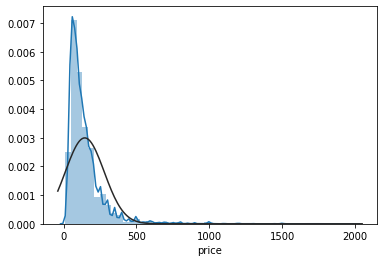

In [62]:
sns.distplot(train['price'],fit=norm);


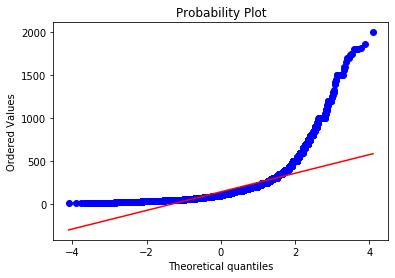

In [63]:
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

In [64]:
train["price"] = np.log1p(train["price"])


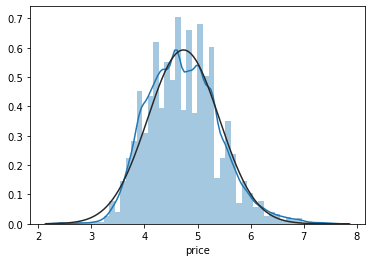

In [65]:
sns.distplot(train['price'],fit=norm);

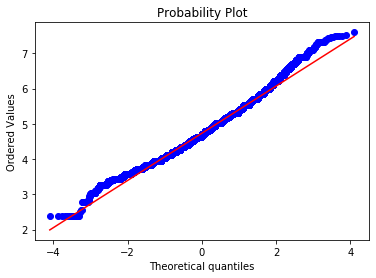

In [66]:
fig = plt.figure()
res = stats.probplot(train['price'], plot=plt)
plt.show()

In [67]:
train_corr = train.corr()
cmap=sns.diverging_palette(5, 250, as_cmap=True)


train_corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\

/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
host_response_rate,1.00,nan,0.24,0.07,0.02,0.01,0.12,0.04,0.07,0.12,0.01,0.04,0.12,0.11,0.01,-0.01,0.23,0.22,0.22,0.23,0.22,0.22,0.22,0.22,0.15,0.34
host_acceptance_rate,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
host_is_superhost,0.24,nan,1.00,-0.02,0.01,-0.00,0.06,-0.00,0.03,0.06,0.02,0.02,0.10,0.10,-0.05,-0.00,0.31,0.22,0.22,0.24,0.21,0.21,0.20,0.22,-0.00,0.33
host_listings_count,0.07,nan,-0.02,1.00,0.00,-0.00,0.00,0.00,-0.03,-0.00,-0.01,0.09,-0.00,-0.05,0.10,-0.00,-0.05,-0.10,-0.11,-0.10,-0.10,-0.11,-0.10,-0.11,0.61,-0.06
host_has_profile_pic,0.02,nan,0.01,0.00,1.00,0.01,0.01,-0.01,-0.00,0.00,0.00,-0.01,0.01,0.01,0.00,0.00,0.01,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.02
host_identity_verified,0.01,nan,-0.00,-0.00,0.01,1.00,0.00,0.01,0.00,-0.00,-0.00,-0.00,0.00,0.01,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,0.01
accommodates,0.12,nan,0.06,0.00,0.01,0.00,1.00,0.33,0.64,0.79,0.05,0.56,0.58,0.12,-0.01,-0.01,0.11,0.07,0.07,0.08,0.07,0.07,0.07,0.07,0.02,0.14
bathrooms,0.04,nan,-0.00,0.00,-0.01,0.01,0.33,1.00,0.39,0.35,0.03,0.19,0.19,0.05,0.02,-0.00,-0.02,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.02,0.02,0.00
bedrooms,0.07,nan,0.03,-0.03,-0.00,0.00,0.64,0.39,1.00,0.66,0.04,0.34,0.42,0.09,0.01,-0.01,0.03,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.03,0.04
beds,0.12,nan,0.06,-0.00,0.00,-0.00,0.79,0.35,0.66,1.00,0.05,0.42,0.52,0.12,0.01,-0.00,0.10,0.05,0.05,0.06,0.05,0.05,0.05,0.05,0.01,0.12


## Features
* host_listing_count
* accomodates
* bathrooms 
* bedrooms
* beds
* guests_included
* extra_people
* calculated_host_listings_count

In [68]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
maximum_nights,183.034554
minimum_nights,22.174780
square_feet,18.944117
host_listings_count,16.372819
calculated_host_listings_count,6.652097
bathrooms,5.193864
extra_people,4.386890
guests_included,3.774951
number_of_reviews,3.574443
beds,3.079938


In [69]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = ['maximum_nights','minimum_nights']
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    train[feat] = boxcox1p(train[feat], lam)
    test[feat] = boxcox1p(test[feat], lam)

There are 26 skewed numerical features to Box Cox transform


In [70]:
train_corr = train.corr()
cmap=sns.diverging_palette(5, 250, as_cmap=True)


train_corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\

/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1089: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/Users/vincewong/opt/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1090: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,square_feet,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
host_response_rate,1.00,nan,0.24,0.07,0.02,0.01,0.12,0.04,0.07,0.12,0.01,0.04,0.12,0.11,0.04,0.01,0.23,0.22,0.22,0.23,0.22,0.22,0.22,0.22,0.15,0.34
host_acceptance_rate,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
host_is_superhost,0.24,nan,1.00,-0.02,0.01,-0.00,0.06,-0.00,0.03,0.06,0.02,0.02,0.10,0.10,-0.08,-0.04,0.31,0.22,0.22,0.24,0.21,0.21,0.20,0.22,-0.00,0.33
host_listings_count,0.07,nan,-0.02,1.00,0.00,-0.00,0.00,0.00,-0.03,-0.00,-0.01,0.09,-0.00,-0.05,0.19,0.07,-0.05,-0.10,-0.11,-0.10,-0.10,-0.11,-0.10,-0.11,0.61,-0.06
host_has_profile_pic,0.02,nan,0.01,0.00,1.00,0.01,0.01,-0.01,-0.00,0.00,0.00,-0.01,0.01,0.01,0.01,-0.00,0.01,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.01,0.02
host_identity_verified,0.01,nan,-0.00,-0.00,0.01,1.00,0.00,0.01,0.00,-0.00,-0.00,-0.00,0.00,0.01,0.01,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.01,0.01
accommodates,0.12,nan,0.06,0.00,0.01,0.00,1.00,0.33,0.64,0.79,0.05,0.56,0.58,0.12,-0.01,0.06,0.11,0.07,0.07,0.08,0.07,0.07,0.07,0.07,0.02,0.14
bathrooms,0.04,nan,-0.00,0.00,-0.01,0.01,0.33,1.00,0.39,0.35,0.03,0.19,0.19,0.05,0.05,0.04,-0.02,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.02,0.02,0.00
bedrooms,0.07,nan,0.03,-0.03,-0.00,0.00,0.64,0.39,1.00,0.66,0.04,0.34,0.42,0.09,0.03,0.03,0.03,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.03,0.04
beds,0.12,nan,0.06,-0.00,0.00,-0.00,0.79,0.35,0.66,1.00,0.05,0.42,0.52,0.12,0.02,0.04,0.10,0.05,0.05,0.06,0.05,0.05,0.05,0.05,0.01,0.12


In [71]:
num = train.corr().columns.tolist()
new_feats = ['accommodates','bathrooms','bedrooms','guests_included','extra_people' ,'calculated_host_listings_count',
      'host_listings_count','minimum_nights', 'maximum_nights']
test_num = test.corr().columns.tolist()
# feat_list = columns we don't want
new_feat_list = np.setdiff1d(num,new_feats).tolist()
new_test_feat_list = np.setdiff1d(test_num, new_feats).tolist()

In [72]:
new_train = train.drop(columns=new_feat_list)
new_test = test.drop(columns=new_test_feat_list)

In [73]:
new_train['price']= price

In [74]:
boroughs = new_train.neighbourhood_group_cleansed.unique().tolist()
def removal_of_outliers(df,room_t, nhood, distance):
    '''Function removes outliers that are above 3rd quartile and below 1st quartile'''
    '''The exact cutoff distance above and below can be adjusted'''

    new_piece = df[(df["room_type"]==room_t)&(df["neighbourhood_group_cleansed"]==nhood)]["price"]
    #defining quartiles and interquartile range
    q1 = new_piece.quantile(0.10)
    q3 = new_piece.quantile(0.90)
    IQR=q3-q1

    trimmed = df[(df.room_type==room_t)&(df["neighbourhood_group_cleansed"]==nhood) &(df.price>(q1-distance*IQR))&(df.price<(q3+distance*IQR))]
    return trimmed

#apply the function
df_private = pd.DataFrame()
for neighborhood in boroughs:
    a = removal_of_outliers(new_train, "Private room",neighborhood,3)
    df_private = df_private.append(a)

df_shared = pd.DataFrame()
for neighborhood in boroughs:
    a = removal_of_outliers(new_train, "Shared room",neighborhood,3)
    df_shared = df_shared.append(a)
    
df_apt = pd.DataFrame()
for neighborhood in boroughs:
    a = removal_of_outliers(new_train, "Entire home/apt",neighborhood,3)
    df_apt = df_apt.append(a)
    
# Create new dataframe to absorb newly produced data    
new_train_old=new_train.copy()    
new_train = pd.DataFrame()
new_train= new_train.append([df_private,df_shared,df_apt])


In [75]:
new_train['price']= price


In [76]:
print(new_train.shape)
print(new_test.shape)

(33323, 49)
(17337, 50)


In [77]:
new_train = new_train[['neighbourhood_group_cleansed','minimum_nights', 'maximum_nights','neighbourhood_cleansed', 'calculated_host_listings_count','room_type', 'accommodates', 
        'bathrooms', 'bedrooms', 
        'guests_included','description','last_review','extra_people', 'host_listings_count','amenities','price']]


new_test = new_test[['neighbourhood_group_cleansed', 'minimum_nights', 'maximum_nights','neighbourhood_cleansed','calculated_host_listings_count','room_type', 'accommodates', 
        'bathrooms', 'bedrooms',
        'guests_included','description','last_review','extra_people', 'amenities','host_listings_count']]


In [78]:
train_corr = new_train.corr()
cmap=sns.diverging_palette(5, 250, as_cmap=True)


train_corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)\

,minimum_nights,maximum_nights,calculated_host_listings_count,accommodates,bathrooms,bedrooms,guests_included,extra_people,host_listings_count,price
minimum_nights,1.00,0.07,0.38,-0.01,0.05,0.03,-0.06,-0.09,0.19,0.04
maximum_nights,0.07,1.00,0.12,0.06,0.04,0.03,0.01,-0.04,0.07,0.08
calculated_host_listings_count,0.38,0.12,1.00,0.03,0.02,-0.03,-0.04,-0.09,0.61,0.09
accommodates,-0.01,0.06,0.03,1.00,0.32,0.64,0.58,0.12,0.00,0.55
bathrooms,0.05,0.04,0.02,0.32,1.00,0.38,0.18,0.05,0.00,0.29
bedrooms,0.03,0.03,-0.03,0.64,0.38,1.00,0.42,0.09,-0.03,0.40
guests_included,-0.06,0.01,-0.04,0.58,0.18,0.42,1.00,0.33,-0.00,0.32
extra_people,-0.09,-0.04,-0.09,0.12,0.05,0.09,0.33,1.00,-0.05,0.10
host_listings_count,0.19,0.07,0.61,0.00,0.00,-0.03,-0.00,-0.05,1.00,0.08
price,0.04,0.08,0.09,0.55,0.29,0.40,0.32,0.10,0.08,1.00


In [79]:
newguys = ['Bedford-Stuyvesant', 'Chelsea','Crown Heights', 'East Village', 'Financial District', "Hell's Kitchen", 'Tribeca', 'Harlem']

In [80]:
cats = ['neighbourhood_group_cleansed','room_type','neighbourhood_cleansed','last_review']
for i in cats:
    new_train = pd.concat([new_train, pd.get_dummies(new_train[i], drop_first=False)], axis=1)
    new_train.drop([i],axis=1, inplace=True)
    new_test = pd.concat([new_test, pd.get_dummies(new_test[i], drop_first=False)], axis=1)
    new_test.drop([i],axis=1, inplace=True)

In [81]:
new_train['lux'] = new_train['description'].apply(luxonehot)
new_test['lux'] = new_test['description'].apply(luxonehot)

In [82]:
new_train['comfortable'] = new_train['description'].apply(lower)
new_test['comfortable'] = new_test['description'].apply(lower)


new_train['comfortable'] = new_train['description'].apply(comfonehot)
new_test['comfortable'] = new_test['description'].apply(comfonehot)


new_train['lady'] = new_train['description'].apply(ladyonehot)
new_test['lady'] = new_test['description'].apply(ladyonehot)


new_train['girl'] = new_train['description'].apply(girlonehot)
new_test['girl'] = new_test['description'].apply(girlonehot)


    
new_train['awesome'] = new_train['description'].apply(awesomeonehot)
new_test['awesome'] = new_test['description'].apply(awesomeonehot)


new_train['lux'] = new_train['description'].apply(luxonehot)
new_test['lux'] = new_test['description'].apply(luxonehot)


    
new_train['grand'] = new_train['description'].apply(grandonehot)
new_test['grand'] = new_test['description'].apply(grandonehot)



    
new_train['patio'] = new_train['description'].apply(patioonehot)
new_test['patio'] = new_test['description'].apply(patioonehot)


    
new_train['remodel'] = new_train['description'].apply(reonehot)
new_test['remodel'] = new_test['description'].apply(reonehot)


    
new_train['clean'] = new_train['description'].apply(cleanonehot)
new_test['clean'] = new_test['description'].apply(cleanonehot)


    
new_train['modern'] = new_train['description'].apply(modernonehot)
new_test['modern'] = new_test['description'].apply(modernonehot)


    
new_train['view'] = new_train['description'].apply(viewonehot)
new_test['view'] = new_test['description'].apply(viewonehot)


    
new_train['beautiful'] = new_train['description'].apply(beautifulonehot)
new_test['beautiful'] = new_test['description'].apply(beautifulonehot)


    
new_train['nightlife'] = new_train['description'].apply(nightlifeonehot)
new_test['nightlife'] = new_test['description'].apply(nightlifeonehot)


new_train['afford'] = new_train['description'].apply(affordableeonehot)
new_test['afford'] = new_test['description'].apply(affordableeonehot)


    
new_train['cheap'] = new_train['description'].apply(cheaponehot)
new_test['cheap'] = new_test['description'].apply(cheaponehot)


    
new_train['new'] = new_train['description'].apply(newonehot)
new_test['new'] = new_test['description'].apply(newonehot)



    
new_train['roof'] = new_train['description'].apply(roofonehot)
new_test['roof'] = new_test['description'].apply(roofonehot)


new_train['renovated'] = new_train['description'].apply(renovatedonehot)
new_test['renovated'] = new_test['description'].apply(renovatedonehot)


    
new_train['hiline'] = new_train['description'].apply(lineonehot)
new_test['hiline'] = new_test['description'].apply(lineonehot)

new_train['loc'] = new_train['description'].apply(loconehot)
new_test['loc'] = new_test['description'].apply(loconehot)

In [83]:
new_train=new_train.drop(columns='description')
new_test=new_test.drop(columns='description')

In [84]:
def amenities_count(a):
    a = a.strip('{')
    a = a.strip('}')
    return len(a.split(','))
new_train['amenities']=new_train['amenities'].apply(amenities_count)
new_test['amenities']=new_test['amenities'].apply(amenities_count)

In [85]:
bk = ['accommodates','bathrooms','bedrooms', 'guests_included','extra_people' ,'calculated_host_listings_count',
      'host_listings_count','Brooklyn', 'Manhattan','Queens', 'Bronx', 'Entire home/apt', 'Private room', 
      'Shared room', 'minimum_nights', 'maximum_nights',
      'Bushwick', 'Midtown', 'Chelsea', 'SoHo', 'West Village','comfortable','lux',
      'modern','clean', 'beautiful','Last_review_never','amenities']
new_train = new_train[bk]
new_train['price'] = price
new_test = new_test[bk]

In [86]:
new_train

,accommodates,bathrooms,bedrooms,guests_included,extra_people,calculated_host_listings_count,host_listings_count,Brooklyn,Manhattan,Queens,Bronx,Entire home/apt,Private room,Shared room,minimum_nights,maximum_nights,Bushwick,Midtown,Chelsea,SoHo,West Village,comfortable,lux,modern,clean,beautiful,Last_review_never,amenities,price
3,1,1.0,1.0,1,0.0,1,1.0,1,0,0,0,0,1,0,1.540963,12.460009,0,0,0,0,0,1,0,0,0,0,1,19,42.0
4,2,1.0,1.0,1,14.0,1,1.0,1,0,0,0,0,1,0,0.730463,6.448232,0,0,0,0,0,1,0,0,0,0,0,19,80.0
12,2,1.0,1.0,1,0.0,2,2.0,1,0,0,0,0,1,0,0.730463,12.460009,0,0,0,0,0,0,0,0,0,0,1,16,70.0
13,2,1.0,1.0,1,25.0,1,1.0,1,0,0,0,0,1,0,1.194318,3.438110,0,0,0,0,0,1,0,0,0,0,0,21,59.0
18,1,1.0,1.0,1,0.0,2,2.0,1,0,0,0,0,1,0,1.194318,5.684507,0,0,0,0,0,1,0,0,0,0,0,8,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32409,2,1.0,1.0,2,25.0,1,1.0,0,0,0,1,1,0,0,1.194318,4.492018,0,0,0,0,0,1,0,0,0,0,0,26,60.0
32583,4,1.0,2.0,1,18.0,4,4.0,0,0,0,1,1,0,0,1.540963,4.380946,0,0,0,0,0,1,0,0,1,0,0,29,79.0
33015,2,1.0,0.0,10,10.0,1,1.0,0,0,0,1,1,0,0,0.730463,4.437269,0,0,0,0,0,0,0,0,0,0,0,34,95.0
33183,1,1.0,1.0,1,0.0,1,1.0,0,0,0,1,1,0,0,1.194318,9.492944,0,0,0,0,0,1,0,0,0,0,1,10,65.0


In [87]:
X = new_train.drop(columns='price')
y = new_train['price']

In [88]:
reg = LinearRegression().fit(X, y)
pred = reg.predict(new_test)

In [89]:
output_df5 = pd.DataFrame()
output_df5['Id'] = test_ids
output_df5['Predicted']= pred

In [90]:
DTree=DecisionTreeRegressor(min_samples_leaf=.01)
DTree.fit(X,y)
y_predict=DTree.predict(X)
y_predict_test=DTree.predict(new_test)

In [91]:
rmse = np.sqrt(mean_squared_error(y, y_predict))
rmse

79.40398677079759

In [92]:
output_df6 = pd.DataFrame()
output_df6['Id'] = test_ids
output_df6['Predicted']= y_predict_test
output_df6

,Id,Predicted
0,19307997,397.602349
1,20176193,170.904847
2,19485371,90.843305
3,13079990,68.489684
4,22339757,58.255556
...,...,...
17332,22325617,72.983908
17333,8372650,229.325843
17334,3812554,74.674863
17335,18891508,62.592357


In [93]:
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X, y)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [94]:
testpred = reg.predict(new_test)

In [95]:
output_df7 = pd.DataFrame()
output_df7['Id'] = test_ids
output_df7['Predicted']= testpred
output_df7

,Id,Predicted
0,19307997,362.065822
1,20176193,147.489546
2,19485371,72.918291
3,13079990,69.082077
4,22339757,56.163032
...,...,...
17332,22325617,70.133415
17333,8372650,268.320236
17334,3812554,69.453242
17335,18891508,61.489603


In [97]:
output_df7.to_csv('submssion51.csv',index=False)